In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from markethistory import *

In [3]:
BATCH_SIZE = 109
NUM_FEATURE = 3
NUM_ASSET = 12
OBS_WINDOW = 31

EPISODE_WINDOW = 31

TXN_FEE = 0.0025
SAMPLING_BIAS = 1.5e-3 # This number needs to be carefully chosen.

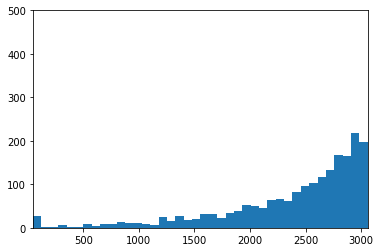

mean:  2395.246
std:  641.866515316


In [30]:
# Find a good SAMPLING_BIAS

def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

start, end = 50, 3060 # end is the total time length of training data
data = [sample(start, end, 1.5e-3) for _ in range(2000)]
plt.hist(data, 40)
plt.axis([start, end, 0, 500])
plt.show()
print("mean: ", np.mean(data))
print("std: ", np.std(data))

#### Read price history from database

In [4]:
start = '2018/01/20'
end = '2018/04/20'
markethistory = MarketHistory(start, end)

#### Add constant cash (BTC) price info

In [97]:
data_global = markethistory.data
num_feature, num_asset, T = data_global.shape
btc_price_tensor = np.ones((num_feature, 1, T))
data_global = np.concatenate((btc_price_tensor, data_global), axis=1)
print("Global data tensor shape:", data_global.shape)

Global data tensor shape: (3, 12, 4319)


#### Split data into train, validataion, test

In [98]:
T_test = int(0.1 * T)
T_valid = int(0.2 * T)
T_train = T - T_test - T_valid

data_global = torch.tensor(data_global, dtype=torch.float)
data_train = data_global[:, :, :T_train]
data_valid = data_global[:, :, T_train:T_train+T_valid]
data_test = data_global[:, :, T_train+T_valid:]
print("Training data tensor shape:   ", data_train.shape)
print("Validation data tensor shape: ", data_valid.shape)
print("Testing data tensor shape:    ", data_test.shape)

Training data tensor shape:    torch.Size([3, 12, 3025])
Validation data tensor shape:  torch.Size([3, 12, 863])
Testing data tensor shape:     torch.Size([3, 12, 431])


#### Define Policy

In [99]:
class DecisionNetwork_CNN(nn.Module):
    """
    An EIIE style decision network implemented with CNN without separate
    cash bias.
    """
    
    def __init__(self):
        super(DecisionNetwork_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=NUM_FEATURE, 
                               out_channels=3, #2 
                               kernel_size=[1,2]) # can also use [1,3]
        self.conv2 = nn.Conv2d(in_channels=3, 
                               out_channels=10, # can also use 10
                               kernel_size=[1, OBS_WINDOW-1])
        self.conv3 = nn.Conv2d(in_channels=11, 
                               out_channels=1, 
                               kernel_size=[1, 1])
        
    def forward(self, obs, prev_pf_w):
        """
        Compute the forward pass. 
        
        Input:
        - obs: A fresh observation of the market environment at the current time step.
          A tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW].
        - prev_pf_w: The portfolio weight vector in the previous time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET].
        
        Returns:
        - new_pf_w: The new portfolio weight vector for the current time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET]
        """
        scores = nn.ReLU()(self.conv1(obs))
        scores = nn.ReLU()(self.conv2(scores))
        scores = torch.cat([scores, prev_pf_w.view(BATCH_SIZE, 1, NUM_ASSET, 1)], dim=1)
        scores = self.conv3(scores).squeeze()
        
        new_pf_w = F.softmax(scores, dim=1)
        return new_pf_w

#### Define helper functions for training

In [100]:
def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

def sample_batch(batch_size, start, end, bias):
    """
    Sample a batch of numbers geometrically distributed in [START, END)
    """
    return torch.tensor([sample(start, end, bias) for _ in range(batch_size)])

def get_observation(end_t_batch, history):
    """
    Get a batch of price history of length OBS_WINDOW, ending at END_T_BATCH (inclusive).
    
    Input:
    - end_t_batch: The end time indices of this observation. Shape: [BATCH_SIZE].
    - history: The price history tensor of shape [NUM_FEATURE, NUM_ASSET, T]
    
    Returns:
    - obs: A torch tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW]
    """
    obs = []
    for offset in range(OBS_WINDOW-1, -1, -1):
        t_batch = end_t_batch - offset
        observation = history[:, :, t_batch].permute(2, 0, 1)
        obs.append(observation)
    obs = torch.stack(obs, dim=-1)
    
    # normalize each asset's prices by its lastest closing prices
    last_close_prices = obs[:, 0, :, -1]
    tmp = obs.permute([1, 3, 0, 2]) / last_close_prices
    obs = tmp.permute([2, 0, 3, 1])
    
    return obs

def calculate_shrinkage(w, w_prev):
    """
    Calculate the porfolio value shrinkage during a portfolio weight re-allocation due
    to transaction fees.
    This function calculates the shrinkage using an iterative approximation method. See
    equation (14) of the Deep Portfolio Management paper. 
    
    Input:
    - w: Target portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    - w_prev: Previous portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    
    Returns:
    - shrinkage: Portfolio value shrinkage multipler tensor of shape [BATCH_SIZE]
    """
    w0_0, w0_m = w_prev[:, 0], w_prev[:, 1:]
    w1_0, w1_m = w[:, 0], w[:, 1:]
    
    const1 = 1 - TXN_FEE * w0_0
    const2 = 2 * TXN_FEE - TXN_FEE ** 2
    const3 = 1 - TXN_FEE * w1_0
    
    u = TXN_FEE * torch.sum(torch.abs(w0_m - w1_m))
    w1_m_T = w1_m.transpose(0, 1)
    while True:
        u_next = (const1 - const2*torch.sum(F.relu(w0_m - (u*w1_m_T).transpose(0,1)), dim=1)) / const3
        max_diff = torch.max(torch.abs(u - u_next))
        if max_diff <= 1e-10:
            return u_next
        u = u_next

#### Define training

In [101]:
# TODO: instaed of fixed window size, try randomized window size
# TODO: modify data matrix so that it includes a row of 1 for Cash
# TODO: think of better way to initialize the initial pf weights

def train(policy, data, lr=1e-3, episodes=10000):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    T = data.shape[-1]
    
    for i in range(episodes):
        # geometrically sample start times: [batch]
        start_indices = sample_batch(BATCH_SIZE, OBS_WINDOW, T-EPISODE_WINDOW, SAMPLING_BIAS)
        # initialize portfolio weights: [batch, asset]
        pf_w = (torch.ones(NUM_ASSET) / NUM_ASSET).repeat(BATCH_SIZE, 1)
        # initialize portfolio values: [batch]
        pf_v = torch.ones(BATCH_SIZE)
        
        # simulate one episode of live trading with the policy
        loss = 0
        price_curr = data[0, :, start_indices].transpose(0, 1) # [batch, asset]
        for t in range(0, EPISODE_WINDOW):
            price_next = data[0, :, start_indices+t+1].transpose(0, 1) # [batch, asset]
            obs = get_observation(start_indices+t, data)
            
            pf_w_t_start = policy.forward(obs, pf_w)
            shrinkage = calculate_shrinkage(pf_w_t_start, pf_w)
            pf_v_t_start = pf_v * shrinkage
            
            w_tmp = (price_next / price_curr) * pf_w_t_start # [batch, asset]
            w_tmp_sum = torch.sum(w_tmp, dim=1) # [batch]
            pf_v_t_end = w_tmp_sum * pf_v_t_start
            pf_w_t_end = w_tmp / w_tmp_sum.view(BATCH_SIZE, 1)
            
            batch_reward = torch.log(pf_v_t_end / pf_v)
            loss -= torch.sum(batch_reward) / BATCH_SIZE
            
            # update variables
            pf_w = pf_w_t_end
            pf_v = pf_v_t_end
            price_curr = price_next
        #loss /= EPISODE_WINDOW
        
        if i % 10  == 0:
            print("episode", i, " loss:", float(loss))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# THE REAL DEAL

In [102]:
policy = DecisionNetwork_CNN()

In [103]:
train(policy, data_train, lr=1e-3, episodes=1000)

episode 0  loss: 0.0029551482293754816
episode 10  loss: 0.003003244288265705
episode 20  loss: 0.004165754187852144
episode 30  loss: 0.002874894766137004
episode 40  loss: 0.003576502436771989
episode 50  loss: 0.005783560685813427
episode 60  loss: 0.0027761817909777164
episode 70  loss: 0.0044067613780498505
episode 80  loss: 0.0014017545618116856
episode 90  loss: 0.004671019967645407
episode 100  loss: 0.002409137086942792
episode 110  loss: 0.0032139974646270275
episode 120  loss: 0.002336036879569292
episode 130  loss: 0.004934850614517927
episode 140  loss: 0.006543042603880167
episode 150  loss: 0.0024792987387627363
episode 160  loss: 0.004526783712208271
episode 170  loss: 0.002908544149249792
episode 180  loss: 0.0035550445318222046
episode 190  loss: 0.003895254572853446
episode 200  loss: 0.004171337001025677
episode 210  loss: 0.0026458639185875654
episode 220  loss: 0.002868740586563945
episode 230  loss: 0.005587816704064608
episode 240  loss: 0.009345266036689281
epi

In [54]:
def get_obs(end_t, history):
    obs = []
    last_close = history[0, :, end_t]
    for t in range(end_t - OBS_WINDOW + 1, end_t+1):
        observation = history[:, :, t] / last_close
        obs.append(observation)
    obs = torch.stack(obs, dim=-1)
    return obs

def calc_mu(w, w_prev):
    w0_0, w0_m = w_prev[0], w_prev[1:]
    w1_0, w1_m = w[0], w[1:]
    
    const1 = 1 - TXN_FEE * w0_0
    const2 = 2 * TXN_FEE - TXN_FEE ** 2
    const3 = 1 - TXN_FEE * w1_0
    
    u = TXN_FEE * torch.sum(torch.abs(w0_m - w1_m))
    while True:
        u_next = (const1 - const2*torch.sum(F.relu(w0_m - u*w1_m))) / const3
        if torch.abs(u - u_next) <= 1e-10:
            return u_next
        u = u_next

In [105]:
def backtest(policy, data):
    # data := [feat, asset, T]
    T = data.shape[-1]
    
    start_indices = torch.tensor([0 for _ in range(BATCH_SIZE)])
    pf_w = torch.tensor([1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).repeat(BATCH_SIZE, 1)
    pf_v = torch.ones(BATCH_SIZE)
    
    price_curr = data[0, :, start_indices].transpose(0, 1) # [batch, asset]
    
    pv_list = []
    for t in range(0, T-1):
        pv_list.append(float(pf_v[0]))
        
        price_next = data[0, :, start_indices+t+1].transpose(0, 1) # [batch, asset]
        obs = get_observation(start_indices+t, data)

        pf_w_t_start = policy.forward(obs, pf_w)
        shrinkage = calculate_shrinkage(pf_w_t_start, pf_w)
        pf_v_t_start = pf_v * shrinkage

        w_tmp = (price_next / price_curr) * pf_w_t_start # [batch, asset]
        w_tmp_sum = torch.sum(w_tmp, dim=1) # [batch]
        pf_v_t_end = w_tmp_sum * pf_v_t_start
        pf_w_t_end = w_tmp / w_tmp_sum.view(BATCH_SIZE, 1)

        #batch_reward = torch.log(pf_v_t_end / pf_v)
        #loss -= torch.sum(batch_reward) / BATCH_SIZE

        # update variables
        pf_w = pf_w_t_end
        pf_v = pf_v_t_end
        price_curr = price_next
    return pv_list

In [106]:
pv_train1 = backtest(policy, data_train)
pv_valid1 = backtest(policy, data_valid)

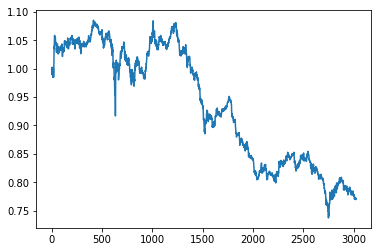

In [107]:
plt.plot(pv_train1)

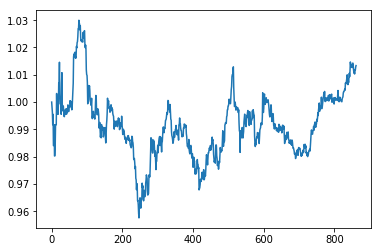

In [108]:
plt.plot(pv_valid1)

In [109]:
mean_train = np.mean(pv_train1)
mean_valid = np.mean(pv_valid1)
std_train = np.std(pv_train1)
std_valid = np.std(pv_valid1)

sharpe_train = mean_train / std_train
sharpe_valid = mean_valid / std_valid
print(sharpe_train, sharpe_valid)

9.07833095846 82.6715202728


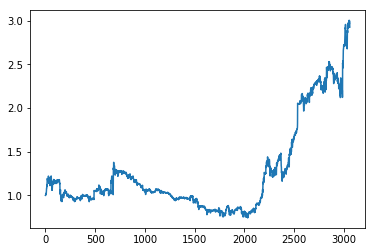

In [92]:
plt.plot(pv_train)

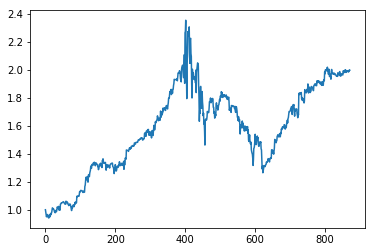

In [93]:
plt.plot(pv_valid)

In [104]:
mean_train = np.mean(pv_train)
mean_valid = np.mean(pv_valid)
std_train = np.std(pv_train)
std_valid = np.std(pv_valid)

sharpe_train = mean_train / std_train
sharpe_valid = mean_valid / std_valid
print(sharpe_train, sharpe_valid)

2.42545151294 5.07818424946
